## Decision Trees using ID3 Algorithm Implementation from scratch

In [4]:
pip install decision-tree-id3

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.0 MB/s eta 0:00:00
  Created wheel for decision-tree-id3: filename=decision_tree_id3-0.1.2-py3-none-any.whl size=15937 sha256=37f27868d7fe5f8d40a099d2b9167167f1befeb57ab6c88c70c924a0acfedcab
  Stored in directory: /root/.cache/pip/wheels/b5/48/52/e8ac7a547a6343fce8e441f4db4a9052c7a8547fd91f413363
Successfully built decision-tree-id3


In [7]:
# Imports
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
import time
from sklearn.tree import export_graphviz
from graphviz import Source
from graphviz import Digraph
from IPython.display import display, Image
from id3 import Id3Estimator

In [8]:
class Node:
    """Node class for Decision Tree."""
    def __init__(self, feature=None, value=None, result=None):
        """
        Initialize a node for the Decision Tree.

        Args:
        - feature: Feature to split on
        - value: Value of the feature to split on
        - result: Result if node is a leaf node
        """
        self.feature = feature
        self.value = value
        self.result = result
        self.children = {}

class DecisionTreeID3:
    """ID3 Decision Tree implementation."""
    def __init__(self, max_depth=None):
        """
        Initialize Decision Tree model.

        Args:
        - max_depth: Maximum depth of the tree
        """
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        """
        Fit the Decision Tree to the given data.

        Args:
        - X: Feature matrix
        - y: Target labels
        """
        self.X = X
        self.y = y
        self.features = X.columns
        self.classes = y.unique()
        self.root = self.build_tree(X, y, depth=0)

    def build_tree(self, X, y, depth):
        """
        Recursively build the decision tree.

        Args:
        - X: Feature matrix
        - y: Target labels
        - depth: Current depth of the tree

        Returns:
        - node: Root node of the built subtree
        """
        if depth == self.max_depth or len(set(y)) == 1:
            return Node(result=self.most_common_label(y))
        if len(X.columns) == 0:
            return Node(result=self.most_common_label(y))

        best_feature, best_value = self.find_best_split(X, y)
        node = Node(feature=best_feature, value=best_value)

        left_X, left_y, right_X, right_y = self.split_dataset(X, y, best_feature, best_value)

        node.children['left'] = self.build_tree(left_X, left_y, depth + 1)
        node.children['right'] = self.build_tree(right_X, right_y, depth + 1)

        return node

    def find_best_split(self, X, y):
        """
        Find the best feature and value to split on based on information gain.

        Args:
        - X: Feature matrix
        - y: Target labels

        Returns:
        - best_feature: Feature with the highest information gain
        - best_value: Value of the feature with the highest information gain
        """
        best_gain = -1
        best_feature = None
        best_value = None

        for feature in X.columns:
            values = X[feature].unique()
            for value in values:
                left_indices = X[feature] <= value
                right_indices = X[feature] > value

                gain = self.information_gain(y, y[left_indices], y[right_indices])

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_value = value

        return best_feature, best_value

    def information_gain(self, parent, left, right):
        """
        Calculate information gain based on entropy.

        Args:
        - parent: Parent node labels
        - left: Left child node labels
        - right: Right child node labels

        Returns:
        - information_gain: Information gain
        """
        total = len(parent)
        pl = len(left) / total
        pr = len(right) / total

        return self.entropy(parent) - (pl * self.entropy(left) + pr * self.entropy(right))

    def entropy(self, y):
        """
        Calculate entropy of a set of labels.

        Args:
        - y: Labels

        Returns:
        - entropy: Entropy value
        """
        entropy = 0
        total_len = len(y)
        for cls in self.classes:
            count_cls = np.sum(y == cls)
            if count_cls > 0:
                p_cls = count_cls / total_len
                entropy -= p_cls * np.log2(p_cls)
        return entropy

    def most_common_label(self, y):
        """
        Find the most common label in a set of labels.

        Args:
        - y: Labels

        Returns:
        - most_common_label: Most common label
        """
        return y.value_counts().idxmax()

    def split_dataset(self, X, y, feature, value):
        """
        Split dataset based on a feature and value.

        Args:
        - X: Feature matrix
        - y: Target labels
        - feature: Feature to split on
        - value: Value of the feature to split on

        Returns:
        - left_X: Left subset of feature matrix
        - left_y: Left subset of target labels
        - right_X: Right subset of feature matrix
        - right_y: Right subset of target labels
        """
        left_indices = X[feature] <= value
        right_indices = X[feature] > value

        left_X = X[left_indices]
        left_y = y[left_indices]
        right_X = X[right_indices]
        right_y = y[right_indices]

        return left_X, left_y, right_X, right_y

    def predict(self, X):
        """
        Predict the labels for the given feature matrix.

        Args:
        - X: Feature matrix

        Returns:
        - predictions: Predicted labels
        """
        predictions = []
        for _, row in X.iterrows():
            predictions.append(self.predict_row(row, self.root))
        return pd.Series(predictions)

    def predict_row(self, row, node):
        """
        Predict the label for a single instance.

        Args:
        - row: Single instance (row of feature matrix)
        - node: Current node of the tree

        Returns:
        - result: Predicted label
        """
        if node.result is not None:
            return node.result

        if row[node.feature] <= node.value:
            return self.predict_row(row, node.children['left'])
        else:
            return self.predict_row(row, node.children['right'])


    def visualize_tree(self):
        """
        Visualize the decision tree.
        """
        dot = Digraph()

        def add_nodes_edges(dot, node):
            if node.result is not None:
                dot.node(str(id(node)), str(node.result), shape='oval')
            else:
                dot.node(str(id(node)), str(node.feature))
                if 'left' in node.children:
                    add_nodes_edges(dot, node.children['left'])
                    dot.edge(str(id(node)), str(id(node.children['left'])), '<=' + str(node.value))
                if 'right' in node.children:
                    add_nodes_edges(dot, node.children['right'])
                    dot.edge(str(id(node)), str(id(node.children['right'])), '>' + str(node.value))

        add_nodes_edges(dot, self.root)
        dot.format = 'png'
        dot.render('decision_tree', cleanup=True)
        display(Image(filename='decision_tree.png'))

def accuracy_score(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

## Section one: Data Loading and Preprocessing

In [11]:
from google.colab import files
uploaded = files.upload()

Saving cardio_train.csv to cardio_train.csv


In [12]:
cardio_df=pd.read_csv("cardio_train.csv", sep=';')
categorical_cols = [col for col in cardio_df.columns if cardio_df[col].nunique() <= 3]
# # Dropping real valued features only leaving categorical ones
cardio_categorical = cardio_df[categorical_cols]
X = cardio_categorical.iloc[:, :-1]
Y = cardio_categorical.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,train_size=0.8,random_state=0)

## Section 2: Results of Decision Tree from scratch

In [13]:
train_start_time=time.time()
DT_model = DecisionTreeID3(max_depth=5)
DT_model.fit(X_train, y_train)
train_end_time=time.time()
pred_start_time=time.time()
y_pred = DT_model.predict(X_test)
pred_end_time=time.time()
y_test.reset_index(drop=True, inplace=True)
feature_names=X.columns.tolist()
target_names=Y.head()
tree_accuracy = np.round(accuracy_score(y_test, y_pred),2)
print("From Scratch Decision Tree Accuracy", tree_accuracy)
print("training time:",train_end_time-train_start_time)
print("prediction time:",pred_end_time-pred_start_time)

From Scratch Decision Tree Accuracy 0.59
training time: 0.7697203159332275
prediction time: 0.7717816829681396


## Section 3: Results of Built-in Decision Tree

In [ ]:
scikit_train_start=time.time()
clf = Id3Estimator()
clf.fit(X_train, y_train)
scikit_train_end=time.time()
scikit_pred_start=time.time()
scikit_y_pred = clf.predict(X_test)
scikit_pred_end=time.time()
scikit_accuracy = np.round(accuracy_score(y_test, scikit_y_pred),2)
print("Scikit learn Accuracy= ", scikit_accuracy)
print("training time:",scikit_train_end-scikit_train_start)
print("prediction time:",scikit_pred_end-scikit_pred_start)


Scikit learn Accuracy=  0.59
training time: 0.4992396831512451
prediction time: 0.05534839630126953


## Section 4: Results of From Scratch DT on Students Dataset

In [14]:
from google.colab import files
uploaded = files.upload()

Saving Students.csv to Students.csv


In [15]:
Stud_df=pd.read_csv("Students.csv")
X = Stud_df.iloc[:, :-1]
Y = Stud_df.iloc[:, -1]

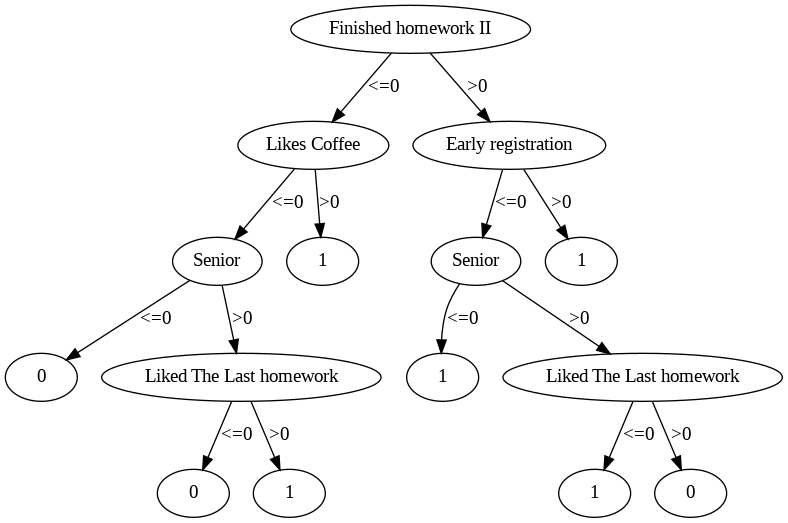

In [16]:
DT_stud_model=DecisionTreeID3(max_depth=4)
DT_stud_model.fit(X,Y)
DT_stud_model.visualize_tree()